# The Validation Experiment Design

## 1.3 Implementing the confusion detection experiment

In [1]:
import torch
import torch.nn as nn
import numpy as np
import copy
from model_classes import InstrumentedTransformer, ModelConfig, ConfusionDetector
from data_generation import generate_arithmetic_batch, VOCAB

def run_confusion_validation():
    """
    The experiment that proves (or disproves) confusion detection
    """
    
    # Initialize
    config = ModelConfig()
    config.vocab_size = VOCAB.vocab_size  # Use actual vocab size
    model = InstrumentedTransformer(config)
    detector = ConfusionDetector()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    results = {
        'phase1_addition': [],
        'phase2a_multiplication': [],
        'phase2b_subtraction': []
    }
    
    # Phase 1: Addition Training
    print("="*60)
    print("Phase 1: Training on Addition")
    print("="*60)
    
    for step in range(500):
        batch = generate_arithmetic_batch(operation='add', batch_size=32)
        
        # Forward pass
        logits, metadata = model(batch['input'], return_metadata=True)
        loss = nn.CrossEntropyLoss(ignore_index=VOCAB.pad_id)(
            logits.view(-1, logits.size(-1)), 
            batch['target'].view(-1)
        )
        
        # Compute confusion metrics
        metrics = detector.compute_all_metrics(model, batch, metadata, loss)
        results['phase1_addition'].append(metrics)
        
        # Train
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            print(f"Step {step:3d} | Loss: {loss.item():.4f} | "
                  f"Attn Entropy: {metrics['attention_entropy']:.4f}")
    
    print(f"\n✓ Addition baseline established")
    print(f"  Final loss: {results['phase1_addition'][-1]['loss']:.4f}")
    
    # Phase 2a: Multiplication (NO training, just measure confusion)
    print("\n" + "="*60)
    print("Phase 2a: Testing on MULTIPLICATION (Architectural Challenge)")
    print("="*60)
    
    model.eval()  # Important: eval mode for testing
    with torch.no_grad():
        for step in range(200):
            batch = generate_arithmetic_batch(operation='multiply', batch_size=32)
            
            logits, metadata = model(batch['input'], return_metadata=True)
            loss = nn.CrossEntropyLoss(ignore_index=VOCAB.pad_id)(
                logits.view(-1, logits.size(-1)), 
                batch['target'].view(-1)
            )
            
            metrics = detector.compute_all_metrics(model, batch, metadata, loss)
            results['phase2a_multiplication'].append(metrics)
            
            if step % 50 == 0:
                print(f"Step {step:3d} | Loss: {loss.item():.4f} | "
                      f"Attn Entropy: {metrics['attention_entropy']:.4f}")
    
    # Phase 2b: Subtraction (NO training, just measure confusion)
    print("\n" + "="*60)
    print("Phase 2b: Testing on SUBTRACTION (Parametric Challenge)")
    print("="*60)
    
    with torch.no_grad():
        for step in range(200):
            batch = generate_arithmetic_batch(operation='subtract', batch_size=32)
            
            logits, metadata = model(batch['input'], return_metadata=True)
            loss = nn.CrossEntropyLoss(ignore_index=VOCAB.pad_id)(
                logits.view(-1, logits.size(-1)), 
                batch['target'].view(-1)
            )
            
            metrics = detector.compute_all_metrics(model, batch, metadata, loss)
            results['phase2b_subtraction'].append(metrics)
            
            if step % 50 == 0:
                print(f"Step {step:3d} | Loss: {loss.item():.4f} | "
                      f"Attn Entropy: {metrics['attention_entropy']:.4f}")
    
    print("\n" + "="*60)
    print("Experiment Complete!")
    print("="*60)
    
    return results

In [6]:
import torch
import importlib
import model_classes
importlib.reload(model_classes)
from model_classes import InstrumentedTransformer, ModelConfig, ConfusionDetector

results = run_confusion_validation()

Phase 1: Training on Addition
Step   0 | Loss: 3.1543 | Attn Entropy: 2.1979
Step 100 | Loss: 1.2235 | Attn Entropy: 1.7412
Step 200 | Loss: 1.0045 | Attn Entropy: 1.6309
Step 300 | Loss: 0.8446 | Attn Entropy: 1.5665
Step 400 | Loss: 0.8942 | Attn Entropy: 1.5330

✓ Addition baseline established
  Final loss: 0.7900

Phase 2a: Testing on MULTIPLICATION (Architectural Challenge)
Step   0 | Loss: 2.9072 | Attn Entropy: 1.4525
Step  50 | Loss: 2.7322 | Attn Entropy: 1.4705
Step 100 | Loss: 3.2209 | Attn Entropy: 1.4417
Step 150 | Loss: 3.1024 | Attn Entropy: 1.4484

Phase 2b: Testing on SUBTRACTION (Parametric Challenge)
Step   0 | Loss: 4.0218 | Attn Entropy: 1.4939
Step  50 | Loss: 3.8147 | Attn Entropy: 1.4842
Step 100 | Loss: 4.8311 | Attn Entropy: 1.5326
Step 150 | Loss: 3.8786 | Attn Entropy: 1.5384

Experiment Complete!


In [10]:
def analyze_confusion_distinguishability(results):
    """
    can we distinguish architectural confusion from parametric confusion?
    look at ALL metrics, not just loss and entropy
    """
    
    import numpy as np
    
    # calculate mean confusion during each phase
    baseline_confusion = {
        metric: np.mean([r[metric] for r in results['phase1_addition'][-100:]])
        for metric in results['phase1_addition'][0].keys()
    }
    
    mult_confusion = {
        metric: np.mean([r[metric] for r in results['phase2a_multiplication'][:50]])
        for metric in results['phase2a_multiplication'][0].keys()
    }
    
    sub_confusion = {
        metric: np.mean([r[metric] for r in results['phase2b_subtraction'][:50]])
        for metric in results['phase2b_subtraction'][0].keys()
    }
    
    print("\n" + "="*70)
    print("CONFUSION DISTINGUISHABILITY ANALYSIS")
    print("="*70)
    
    distinguishable_metrics = []
    
    for metric in baseline_confusion.keys():
        baseline = baseline_confusion[metric]
        mult = mult_confusion[metric]
        sub = sub_confusion[metric]
        
        # calculate relative increases from baseline
        mult_increase = ((mult - baseline) / baseline * 100) if baseline > 0 else 0
        sub_increase = ((sub - baseline) / baseline * 100) if baseline > 0 else 0
        
        # can we distinguish? (>30% difference threshold)
        diff = abs(mult_increase - sub_increase)
        distinguishable = diff > 30
        
        if distinguishable:
            distinguishable_metrics.append((metric, diff))
        
        print(f"\n{metric.upper().replace('_', ' ')}:")
        print(f"  Baseline (addition):     {baseline:.4f}")
        print(f"  Multiplication:          {mult:.4f} ({mult_increase:+.1f}%)")
        print(f"  Subtraction:             {sub:.4f} ({sub_increase:+.1f}%)")
        print(f"  Difference:              {diff:.1f}%")
        print(f"  Distinguishable:         {'YES' if distinguishable else 'NO'}")
    
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    
    if distinguishable_metrics:
        print(f"✓ Found {len(distinguishable_metrics)} distinguishable metrics:")
        for metric, diff in sorted(distinguishable_metrics, key=lambda x: x[1], reverse=True):
            print(f"  - {metric}: {diff:.1f}% difference")
    else:
        print("NO metrics can reliably distinguish the task types")
        print("  -> Hypothesis needs revision")
    
    return baseline_confusion, mult_confusion, sub_confusion

In [11]:
# run the analysis
baseline, mult, sub = analyze_confusion_distinguishability(results)


CONFUSION DISTINGUISHABILITY ANALYSIS

LOSS:
  Baseline (addition):     0.8075
  Multiplication:          2.9620 (+266.8%)
  Subtraction:             3.9889 (+394.0%)
  Difference:              127.2%
  Distinguishable:         YES

ATTENTION ENTROPY:
  Baseline (addition):     1.5207
  Multiplication:          1.4576 (-4.1%)
  Subtraction:             1.5055 (-1.0%)
  Difference:              3.2%
  Distinguishable:         NO

GRADIENT VARIANCE:
  Baseline (addition):     0.1828
  Multiplication:          0.0000 (-100.0%)
  Subtraction:             0.0000 (-100.0%)
  Difference:              0.0%
  Distinguishable:         NO

LAYER DISAGREEMENT:
  Baseline (addition):     0.5707
  Multiplication:          0.5995 (+5.0%)
  Subtraction:             0.5970 (+4.6%)
  Difference:              0.4%
  Distinguishable:         NO

ACTIVATION MAGNITUDE:
  Baseline (addition):     4.4954
  Multiplication:          4.2964 (-4.4%)
  Subtraction:             4.3790 (-2.6%)
  Difference:        

In [14]:
# visualize ALL metrics over time
import matplotlib.pyplot as plt

def visualize_confusion_signals(results):
    
    metrics = ['loss', 'attention_entropy', 'gradient_variance', 
               'layer_disagreement', 'activation_magnitude', 'prediction_confidence']
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('Confusion Signal Validation: x vs -', 
                 fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        # extract metric over time
        addition_values = [r[metric] for r in results['phase1_addition']]
        mult_values = [r[metric] for r in results['phase2a_multiplication']]
        sub_values = [r[metric] for r in results['phase2b_subtraction']]
        
        # plot
        steps_addition = range(len(addition_values))
        steps_mult = range(len(mult_values))
        steps_sub = range(len(sub_values))
        
        ax.plot(steps_addition, addition_values, label='Addition (training)', 
                color='blue', alpha=0.7, linewidth=2)
        ax.plot(steps_mult, mult_values, label='Multiplication (testing)', 
                color='red', linewidth=2, alpha=0.8)
        ax.plot(steps_sub, sub_values, label='Subtraction (testing)', 
                color='orange', linewidth=2, linestyle='--', alpha=0.8)
        
        ax.set_xlabel('Step', fontsize=10)
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)
        
        # add mean lines for test phases
        mult_mean = np.mean(mult_values)
        sub_mean = np.mean(sub_values)
        ax.axhline(y=mult_mean, color='red', linestyle=':', alpha=0.5)
        ax.axhline(y=sub_mean, color='orange', linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('confusion_signal_validation.png', dpi=300, bbox_inches='tight')
    print("Visualization saved: confusion_signal_validation.png")
    plt.show()

Visualization saved: confusion_signal_validation.png


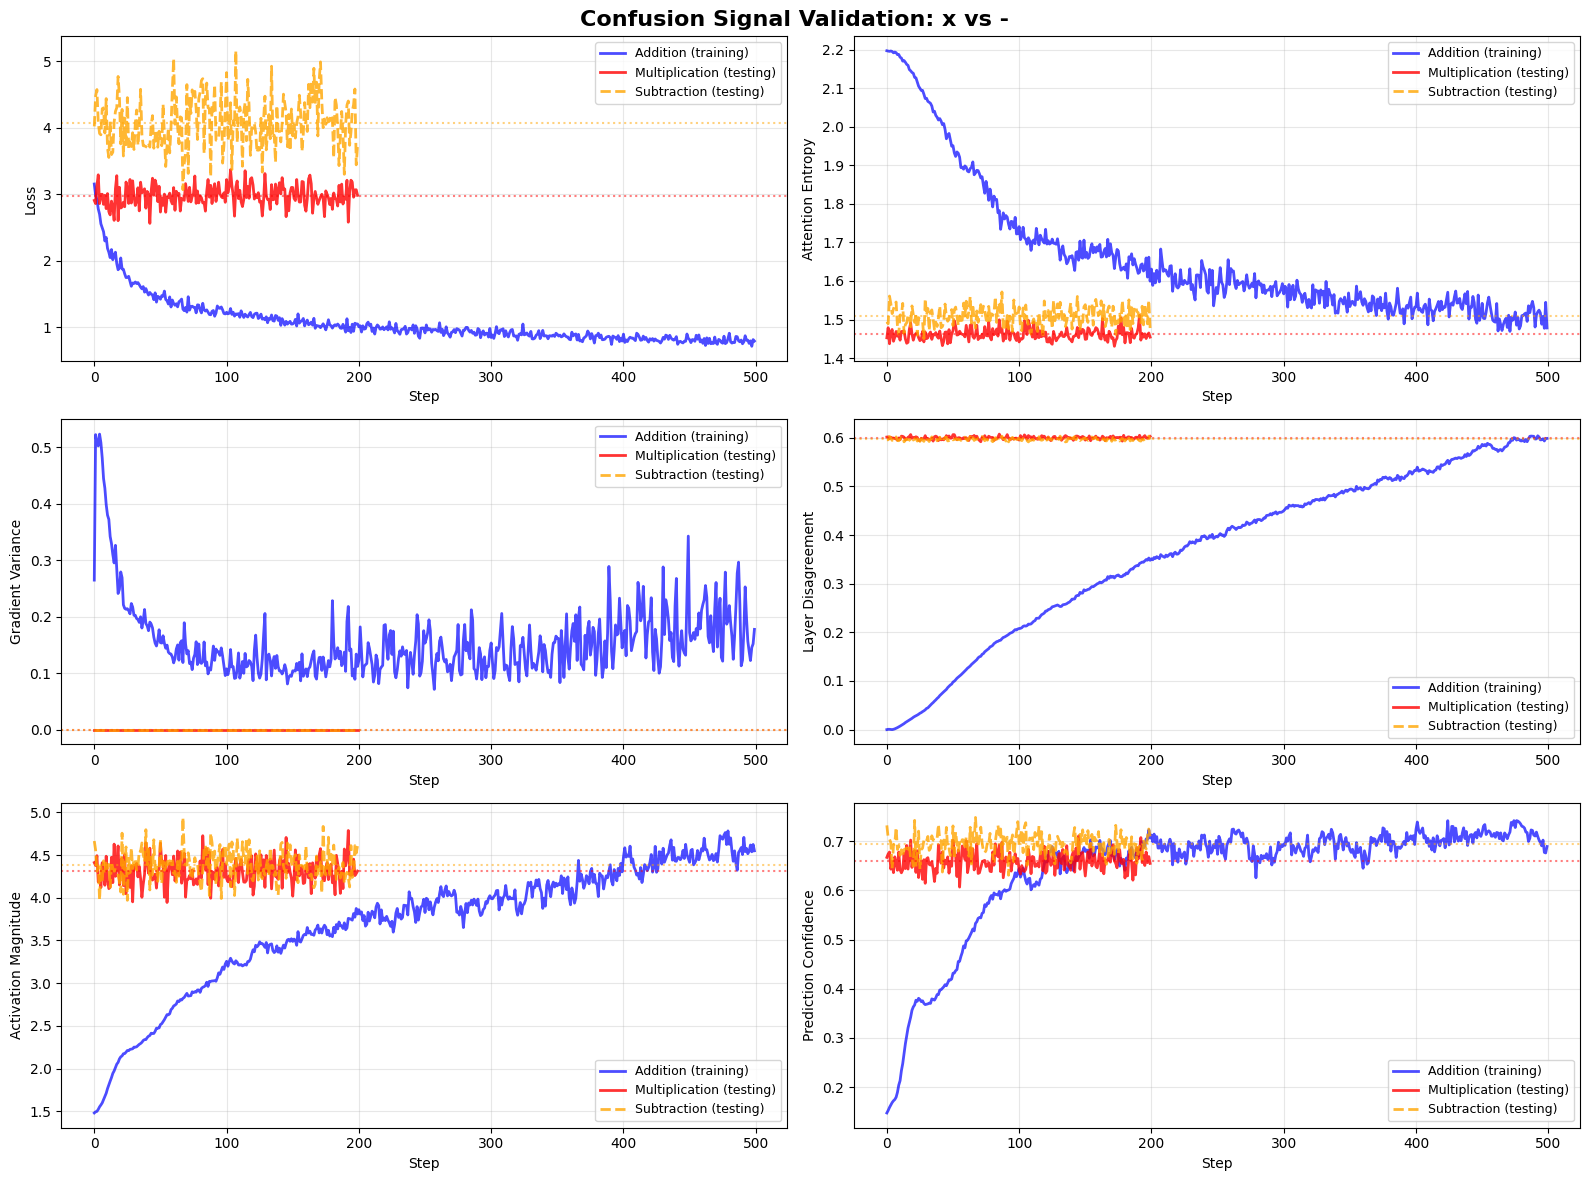

In [15]:
# create visualization
visualize_confusion_signals(results)